# Классификация. Оценочные показатели


In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Задача:

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

In [320]:
df = pd.read_csv('loan_data.csv', sep=',')#, index_col=0)
df.head(3)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1


In [321]:
df["loan_status"].unique() # - бинарная классификация

array([1, 0])

## Обработка признаков (уже делали)

In [322]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
lab_encoder = LabelEncoder()

df["person_gender"] = lab_encoder.fit_transform(df["person_gender"])
df["previous_loan_defaults_on_file"] = lab_encoder.fit_transform(df["previous_loan_defaults_on_file"])
df[['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']].head()

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
0,0,Master,RENT,PERSONAL,0
1,0,High School,OWN,EDUCATION,1
2,0,High School,MORTGAGE,MEDICAL,0
3,0,Bachelor,RENT,MEDICAL,0
4,1,Master,RENT,MEDICAL,0


In [323]:
map_dict = {'High School' : 0,
            'Associate' : 1/4,
            'Bachelor': 2/4,
            'Master' : 3/4,
            'Doctorate' : 1}

df['person_education'] = df['person_education'].map(map_dict)

In [324]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
encode = onehot.fit_transform(df[['person_home_ownership']])
df_encoded = pd.DataFrame(encode.toarray(), columns=onehot.categories_[0])
df = df.join(df_encoded)
df.drop('person_home_ownership', axis = 1, inplace = True)
df = df.drop('OTHER', axis = 1)

In [325]:
onehot = OneHotEncoder()
encode = onehot.fit_transform(df[['loan_intent']])

df_encoded = pd.DataFrame(encode.toarray(), columns=onehot.categories_[0])
df = df.join(df_encoded)
df.drop('loan_intent', axis = 1, inplace = True)

In [326]:
df.loc[:, 'person_income'] = df['person_income'].apply(np.log1p)
df.drop('loan_amnt', axis = 1, inplace = True)

## Оценка модели

Проверим результат. Воспользуемся метрикой Accuracy

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.drop('loan_status', axis = 1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

outliers = X_train[(X_train['person_income']>15) | (X_train['person_age']>100)].index
X_train = X_train.drop(outliers, axis=0)
y_train = y_train.drop(outliers)

In [328]:
model = LogisticRegression(penalty='l2', C=5.0, max_iter=200, solver='newton-cg', random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy = ', metrics.accuracy_score(y_test, y_pred))
print('F1 = ', metrics.f1_score(y_test, y_pred))

Accuracy =  0.8967777777777778
F1 =  0.7654632668518051


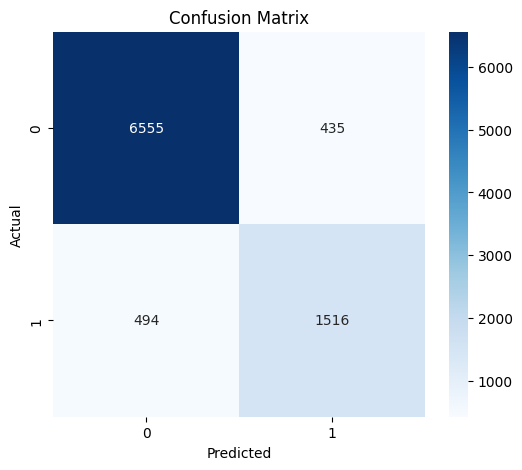

In [329]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Precision & Recall

Precision = TP/(TP+FP)

доля объектов, названных классификатором положительными от всех его положительных ответов

In [330]:
print('precision_score = ', metrics.precision_score(y_test, y_pred))
print('precision_score = ', 1516/(1516+435))

precision_score =  0.7770374167093798
precision_score =  0.7770374167093798


Recall = TP/(TP+FN)

доля объектов, названных классификатором положительными от всех объектов положительного класса

In [331]:
print('recall_score = ', metrics.recall_score(y_test, y_pred))
print('recall_score = ', 1516/(1516+494))

recall_score =  0.7542288557213931
recall_score =  0.7542288557213931


Баланс метрик - среднее гармоническое

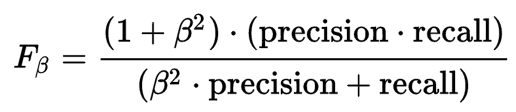

In [332]:
print('F1 = ', metrics.f1_score(y_test, y_pred))

F1 =  0.7654632668518051


## Кривая ROC и оценка AUC

Полнота и точность описывают производительность
классификатора только при определенном пороге. Часто бывает полезно иметь
метрику, которая оценивает производительность классификатора для всех возможных пороговых значений. Основана на двух величинах:

доля ложноположительных результатов

FPR = FP / (FP + TN)

доля истинно положительных результатов

TPR = TP / (TP + FN)

ROC-AUC =  0.8459985480323704


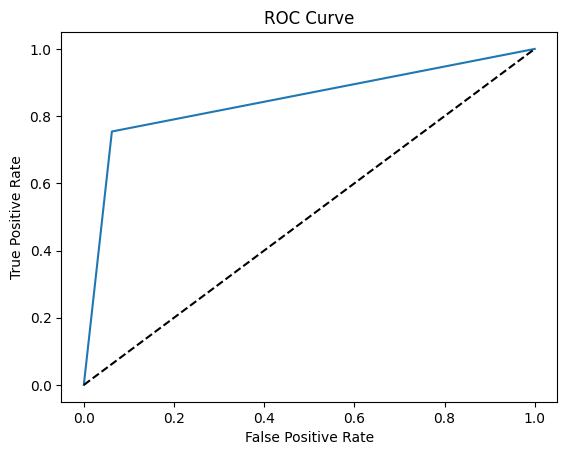

In [333]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#вычисление ROC-AUC
auc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC = ', auc_score)

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()